<a href="https://colab.research.google.com/github/lukaborec/FER2013/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, Input
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
%matplotlib inline

Load the dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv('/content/drive/My Drive/fer2013.csv')

In [0]:
data.shape

(35887, 3)

In [0]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [0]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [0]:
#Expression dictionary
emotion = {0:'Angry', 
           1:'Disgust', 
           2:'Fear', 
           3:'Happy', 
           4:'Sad', 
           5:'Surprise', 
           6:'Neutral'
          }

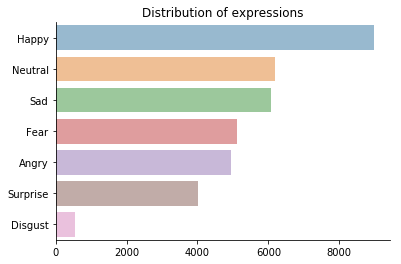

In [0]:
sns.barplot(data['emotion'].astype(int).map(emotion).value_counts().values, 
            data['emotion'].astype(int).map(emotion).value_counts().index,
           alpha=.5)
plt.title('Distribution of expressions')
sns.despine()
plt.show()

The dataset is imbalanced as 'Disgust' has too few entries, so it is dropped from the dataset.

In [0]:
data = data.loc[data['emotion'] != 1]


In [0]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5])

In [0]:
data.loc[data['emotion'] > 1, 'emotion'] -= 1 

In [0]:
data.emotion.unique()

array([0, 1, 3, 5, 2, 4])

In [0]:
#New expression dictionary
emotion = {0:'Angry', 
           1:'Fear', 
           2:'Happy', 
           3:'Sad', 
           4:'Surprise', 
           5:'Neutral'
          }

In [0]:
data['emotion'].astype(int).map(emotion).value_counts()

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Name: emotion, dtype: int64

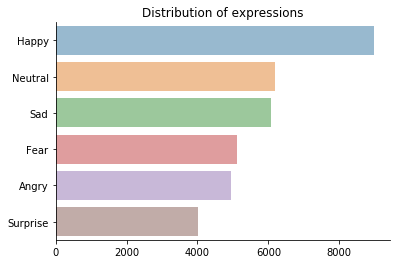

In [0]:
sns.barplot(data['emotion'].astype(int).map(emotion).value_counts().values, 
            data['emotion'].astype(int).map(emotion).value_counts().index,
           alpha=.5)
plt.title('Distribution of expressions')
sns.despine()
plt.show()

In [0]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

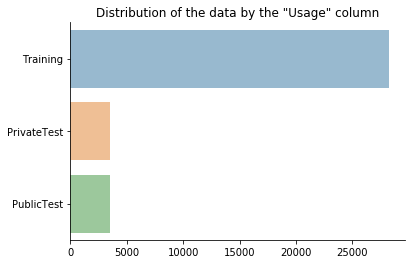

In [0]:
sns.barplot(data['Usage'].value_counts().values,
           data['Usage'].value_counts().index,
           alpha=.5)
plt.title('Distribution of the data by the "Usage" column')
sns.despine()
plt.show()

Preprocessing

In [0]:
training_data = data[data['Usage'] == 'Training']['pixels']

validation_data = data[data['Usage'] == 'PrivateTest']['pixels']

testing_data = data[data['Usage'] == 'PublicTest']['pixels']

In [0]:
training_data.shape

(28273,)

In [0]:
validation_data.shape

(3534,)

In [0]:
testing_data.shape

(3533,)

Reshaping strings into a 48 by 48 matrix of integers.

In [0]:
def adjust_pixels(string):
    return np.array([int(s) for s in string.split()])

In [0]:
training_data = training_data.apply(adjust_pixels).values
validation_data = validation_data.apply(adjust_pixels).values
testing_data = testing_data.apply(adjust_pixels).values

In [0]:
train = list()
for arr in training_data:
    arr = np.reshape(arr, (48,48))
    train.append(arr)
train = np.array(train)

validate = list()
for arr in validation_data:
    arr = np.reshape(arr, (48,48))
    validate.append(arr)
validate = np.array(validate)

test = list()
for arr in testing_data:
    arr = np.reshape(arr, (48,48))
    test.append(arr)
test = np.array(test)

In [0]:
train.shape

(28273, 48, 48)

In [0]:
validate.shape

(3534, 48, 48)

In [0]:
test.shape

(3533, 48, 48)

Emotion: Fear


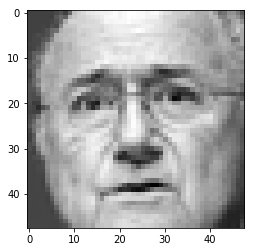

In [0]:
#Example image
plt.imshow(train[5], cmap='gray')
print('Emotion:', emotion[data.iloc[5][0]])

Keras requires categorical labels

In [0]:
train_labels = data[data['Usage'] == 'Training']['emotion']
validation_labels = data[data['Usage'] == 'PrivateTest']['emotion']
test_labels = data[data['Usage'] == 'PublicTest']['emotion']

train_labels = to_categorical(train_labels, num_classes=6)
validation_labels = to_categorical(validation_labels, num_classes=6)
testing_labels = to_categorical(test_labels, num_classes=6)

In [0]:
train_labels.shape

(28273, 6)

In [0]:
#Reshape for CNN
train = train.reshape(train.shape[0], 48, 48, 1)
validate = validate.reshape(validate.shape[0], 48, 48, 1)
test = test.reshape(test.shape[0], 48, 48, 1)

In [0]:
train.shape

(28273, 48, 48, 1)

In [0]:
validate.shape

(3534, 48, 48, 1)

In [0]:
test.shape

(3533, 48, 48, 1)

In [0]:
gen = ImageDataGenerator(rescale=1./255,      #Rescale the data so the values are in range [0,1]
                         rotation_range=20, 
                         zoom_range=0.1,
                         horizontal_flip=True)

In [0]:
#Fit to training data
gen.fit(train)

In [0]:
train_flow = gen.flow(train, train_labels)

In [0]:
#Rescale testing and validation data
test = test / 255.0
#validate = validate / 255.0
testing_gen = ImageDataGenerator(rescale=1./255)
#test_flow = testing_gen.flow(test, test_labels)
validation_flow = testing_gen.flow(validate, validation_labels)

In [0]:
input_layers = Input(shape=(48,48,1), name='input')

conv_2D_1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_layers)
batch_1 = BatchNormalization()(conv_2D_1)

conv_2D_2 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(batch_1)
max_pool_1 = MaxPooling2D((2,2), name='MaxPooling_1')(conv_2D_2)
dropout_1 = Dropout(0.2)(max_pool_1)

conv_2D_3 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(dropout_1)
batch_2 = BatchNormalization()(conv_2D_3)

conv_2D_4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(batch_2)
batch_3 = BatchNormalization()(conv_2D_3)
max_pool_2 = MaxPooling2D((2,2), name='MaxPooling_2')(batch_3)

conv_2D_5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(max_pool_2)
batch_4 = BatchNormalization()(conv_2D_5)

conv_2D_6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(batch_4)
max_pool_3 = MaxPooling2D((2,2), name='MaxPooling_3')(conv_2D_6)

conv_2D_7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(max_pool_3)
batch_5 = BatchNormalization()(conv_2D_7)

flatten = Flatten()(batch_5)

dense_1 = Dense(32, activation='sigmoid', name='dense_1')(flatten)

dense_2 = Dense(64, activation='sigmoid', name='dense_2')(dense_1)

output = Dense(6, activation='softmax', name='output')(dense_2)

model = Model(input_layers, output)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9248

In [0]:
callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [0]:
history = model.fit_generator(train_flow, 
                              steps_per_epoch=len(train)/32, 
                              epochs=50, 
                              callbacks=callback,
                              validation_data=validation_flow,
                              validation_steps=len(validate)/32)

Epoch 1/50
884/883 [==============================] - 365s 413ms/step - loss: 1.5262 - acc: 0.3832 - val_loss: 1.3490 - val_acc: 0.4717
Epoch 2/50
884/883 [==============================] - 370s 418ms/step - loss: 1.3072 - acc: 0.4854 - val_loss: 1.3099 - val_acc: 0.4850
Epoch 3/50
884/883 [==============================] - 367s 415ms/step - loss: 1.2308 - acc: 0.5218 - val_loss: 1.2529 - val_acc: 0.5141
Epoch 4/50
884/883 [==============================] - 366s 414ms/step - loss: 1.1787 - acc: 0.5424 - val_loss: 1.1665 - val_acc: 0.5419
Epoch 5/50
884/883 [==============================] - 364s 412ms/step - loss: 1.1406 - acc: 0.5617 - val_loss: 1.1217 - val_acc: 0.5640
Epoch 6/50
884/883 [==============================] - 364s 412ms/step - loss: 1.1098 - acc: 0.5732 - val_loss: 1.0918 - val_acc: 0.5840
Epoch 7/50
884/883 [==============================] - 362s 409ms/step - loss: 1.0898 - acc: 0.5807 - val_loss: 1.0750 - val_acc: 0.5795
Epoch 8/50
884/883 [============================

Model evaluation using the test set

In [0]:
test_loss, test_acc = model.evaluate(test, testing_labels)

3533/3533 [==============================] - 13s 4ms/step


Changes in loss and accuracy over epochs

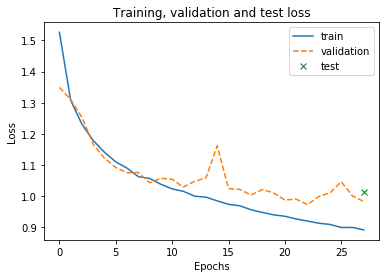

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], '--',label='validation')
plt.plot(27, test_loss,'gx', label='test')
plt.title('Training, validation and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

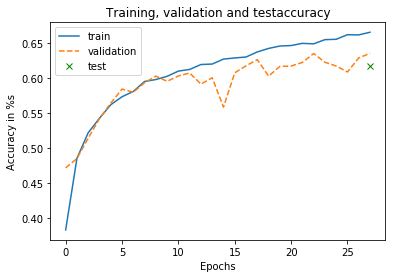

In [0]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], '--', label='validation')
plt.plot(27, test_acc,'gx', label='test')
plt.title('Training, validation and testaccuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy in %s')
plt.legend()
plt.show()

Save the model to json file

In [0]:
#Serialize model to json
json_model = model.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(json_model)
  
#Serialize model to HDF5
model.save_weights('model.h5')
  
  